<a href="https://colab.research.google.com/github/YasmineeBa/Traitement-et-Analyse-d-image/blob/main/Project_TAI/Detection_d'un_polyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Les membres :
# **KOULAL Yidhir Aghiles**
# **LABCHRI Amayas**
# **BAROUD Yasmine**
# **ABCI Fatima**
# G1 Master 1 IV



#Présentation du COLAB : 

Ce colab va présenter l'approche de détection d'un polype suivant une approche tirée d'un article scientfique.\
L'article a pour nom "**Deep CNN and geometric features-based
gastrointestinal tract diseases detection and
classification from wireless capsule endoscopy
images**". Cet article présente une méthode de détection de polype en deux étapes:


1.   Détection d'un polype en utilisant la ségmentation et un réhaussement de couleur.
2.   Classification des polypes en utilisant un réseau de noeurones convolutif *CNN*

Nous allons nous concentrer que sur l'étape 1.

##Plan de travail :

Pour détecter le polyp nous avons 2 étapes: Réhaussement de contraste et Ségemntation des lésions.

###Réhaussement de contraste :

1.   Charger une image pour le traitement
2.   Réhaussement de contraste en appliquant deux filtres (top hat et bottom hat)
3.   Réduire le bruit poivre et sel en appliquant le filtre médian
4.   Changer de domaine de couleur du *RGB* au *CIELAB*

###Ségmentation des lésions :
1. Calculer les caractéristiques de l'image
2. Faire un thresholding de l'image
3. Segmentation 
4. Converssion de l'image segmentée en RGB.


Nous avons suivi le plan c-dessous durant notre implémentation de notre projet :
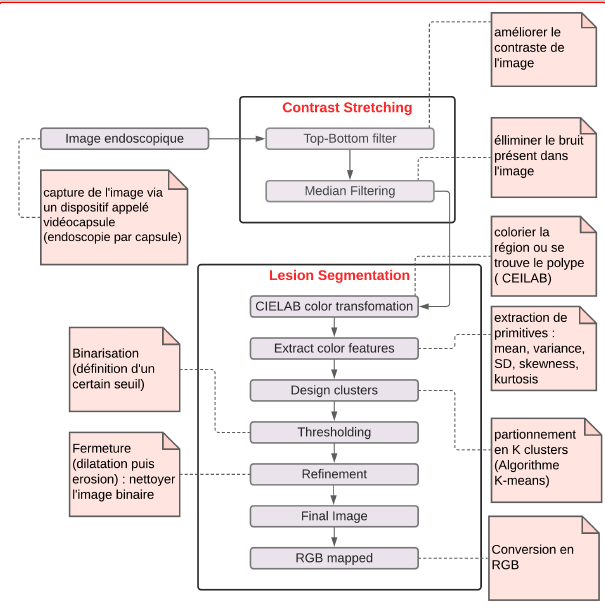---



In [ ]:
import numpy as np
import cv2 
from google.colab.patches import cv2_imshow
from skimage import morphology, io, color
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

#Chargement d'une image de la dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


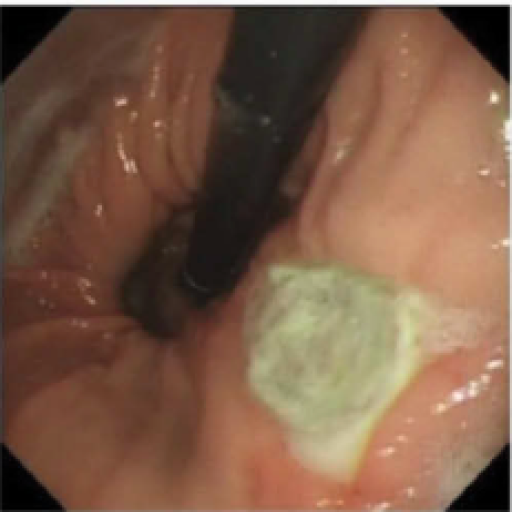

In [ ]:
img= cv2.imread('/content/drive/MyDrive/Colab Notebooks/image.png')
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

##La fonction Enhance_Contrast pour améliorer et augmenter le contraste de l'image

In [ ]:
def Enhance_Contrast(img):
  k = np.ones((35,35),np.uint8)
  topHatFilter = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k) 
  BottomHatFilter = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, k) 
  return((np.array(img,dtype = np.int)+np.array(topHatFilter,dtype = np.int))-np.array(BottomHatFilter,dtype = np.int))

##Fonction pour l'appliquation de filtre médian afin de diminuer le bruit poivre et sel(impulsionnel), avec k comme élément stucturant(masque) fixé a 5 expérimentalement(après plusieur essais). 

In [ ]:
def Median(img, k):
  return cv2.medianBlur(img.astype('int16'), ksize=k)

Nous avons ici deux étapes :  
1. Dans la prmière étape, application des filtres top hat et bottom hat sur l'image afin d'augmenter le contraste. Nous appliquons ces filtres sur chaque canal de l'image(R,G,B).
De ce fait nous allons diviser l'image en 3 canaux.
2. Nous appliquons un réhaussment de contraste pour chaque canal.
3. Combiner chaque canal après l'amélioration du contraste.

c'est ici que ce términe l'étape d'amélioration du contraste.

Maintenant, nous allons appliquer un filtre médian pour chaque canal de l'image en suivant le même principe que celui vu lors de la réhaussement de contraste afin de diminuer le bruit.

etape 1 : Enhance Contrast Using Bottom-hat and Top-hat Filtering (avec OpenCV)
Resultat : 


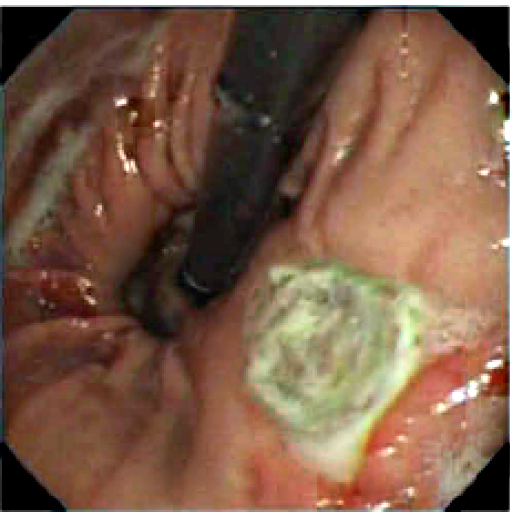

etap2 : Appliquer the 3D Median Filter (avec OpenCV)
Resultat : 


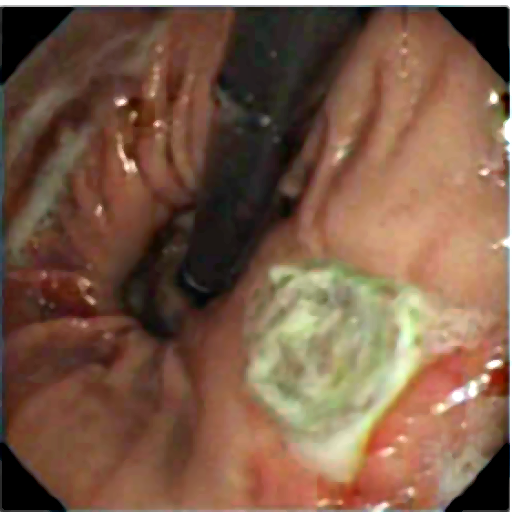

In [ ]:
print("etape 1 : Enhance Contrast Using Bottom-hat and Top-hat Filtering (avec OpenCV)")

b,g,r = cv2.split(img) #diviser l'image en 3 cannaux
b = Enhance_Contrast(b)
g = Enhance_Contrast(g)
r = Enhance_Contrast(r)
img1 = cv2.merge([b, g, r]) #refusionner les cannaux de l'image
print("Resultat : ")
cv2_imshow(img1)

#application du filtre médian
print("etap2 : Appliquer the 3D Median Filter (avec OpenCV)")
b,g,r = cv2.split(img1)
b = Median(b,5)
g = Median(g,5)
r = Median(r,5)

img2 = cv2.merge([b, g, r])

print("Resultat : ")
cv2_imshow(img2)

## Convertir l'image du domaine de Couleur RGB au Cielab

Il est normalement impossible de passer du *RGB* au *LAB* directement, il faudrait passer du *RGB* au *XYZ* puis ensuite du *XYZ* vers le *LAB* mais la librairie skimage à une classe color qui permet de le faire automatiquement.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


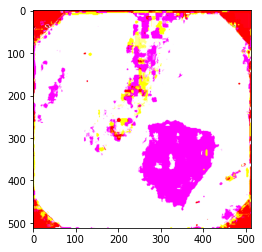

In [ ]:
img3 = np.array(img2, dtype=np.uint8)
b,g,r = cv2.split(img3)
img_3 = cv2.merge([r, g, b])
lab = color.rgb2lab(img_3)
plt.imshow(lab) 
plt.show()

In [ ]:

lab.shape

(512, 512, 3)

#Lesion segmenetation :
Nous allons maintenant passer à l'étape de la détection du polype ou mieux celle de la segmentation.

Pour celà cette étape se compose des étapes suivante : 
1. Extraction des caractéristiques.
2. Thresholding(seuillage) et Création de deux clusters.
3. Segementation.
4. Extraction du polype.
5. Application des filtres morphologiques(fermeture) afin d'améliorer l'image.
6. Transformer notre image segmenté en une image *RGB*

Au niveau de l'étape numéro 3 nous avons essayé deux approche. 
Une approche naive et une segmentation avec K-mean.

Nous allons expliqué chaqu'une par la suite de ce colab.

In [ ]:
def Mean(img_cielab):
  
  img = img_cielab.reshape(-1)
  mean = 0
  for i in range(len(img)):
     mean = mean + (img[i])

  mean = mean / len(img)
  return mean

def MD(img_cielab):
  mean=Mean(img_cielab)
  img = img_cielab.reshape(-1)
  som = 0
  for i in range(len(img)):
    som = som + (img[i] - mean) /len(img)
  return som
def Variance(img_cielab):

  img = img_cielab.reshape(-1)
  som = 0
  variance = 0
  for i in range(len(img)):
    som = som + ((img[i]- mean)**2)

  variance = som / (len(img)-1)

  return variance

def Kurtosis(img_cielab):
  
  img = img_cielab.reshape(-1)
  som = 0
  kurtosis = 0
  SD=np.sqrt(Variance(img_cielab))
  for i in range(len(img)):
    som = som + (img[i] - mean)

  kurtosis = som /(len(img) * (SD **4))
  return kurtosis

def Skewness(img_cielab):

  img = img_cielab.reshape(-1)
  som = 0
  skewness = 0
  SD=np.sqrt(Variance(img_cielab))
  for i in range(len(img)):
    som = som + (((img[i] - mean)/SD) **3)

  skewness = (len(img)/((len(img)-1)*(len(img)-2))) * som

  return  skewness

def MD(img_cielab):
  
  img = img_cielab.reshape(-1)
  som = 0
  for i in range(len(img)):
    som = som + (img[i] - mean) /len(img)
  return som  

In [ ]:
mean = Mean(lab)
md = MD(lab)
print("MD = ",md)
print("mean = ",np.mean(lab))
print("Variance = ",Variance(lab))
print("Kurtosis = ",Kurtosis(lab))
print("Skewness = ",Skewness(lab))

MD =  -2.099788743624648e-12
mean =  23.39901465780982
Variance =  436.99030466189356
Kurtosis =  -1.2144224817512769e-17
Skewness =  0.9768531388794145


# **La Segmentation naive**

SEUILLAGE INVERSE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


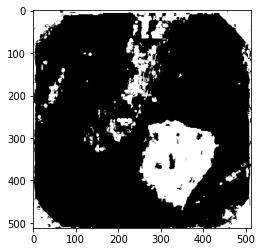

In [ ]:

labc = np.copy(lab)
for i in range(len(labc)):
  for j in range(len(labc[i])):
    if(labc[i][j][0] < md or labc[i][j][1] < md or labc[i][j][2] < md ):   # [0] et [1] et [2] a cause de 3 eme parametre de lab.shape=(237,248,   3)3 canal cad 3 couleur
      labc[i][j] = [255,255,255]  #cluster C1 (en blanc)
    
    else:
      labc[i][j] = [0,0,0]  #cluster C2 (en noir)

plt.imshow(labc)





Appliquer une fermeture "CLOSING" (dilatation puis érosion) pour boucher les trous de l'image.
le k (masque) est fixé experimentalement aussi.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


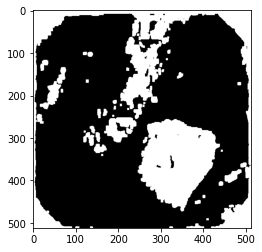

In [ ]:
kernel = np.ones((5,5), np.uint8)
dil_lab = cv2.dilate(labc, kernel, iterations=1)
plt.imshow(dil_lab)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


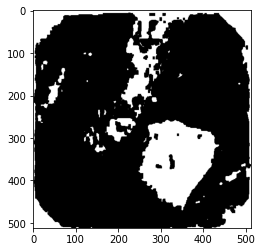

In [ ]:
ero_lab = cv2.erode(dil_lab, kernel, iterations=1)

plt.imshow(ero_lab)


 L'extraction du polype





In [ ]:
#conversion en uint8
img4 = ero_lab.astype(np.uint8)
#conversion en gray
imm = cv2.cvtColor(img4,cv2.COLOR_BGR2GRAY)
#detection des contours avec la fonction findContours 
cont,hei= cv2.findContours(imm,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

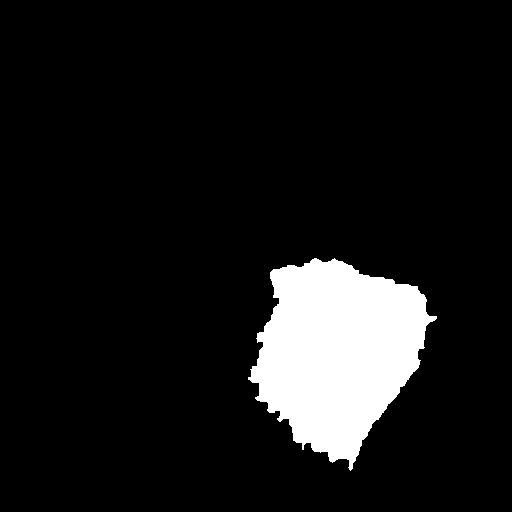

In [ ]:
mask_polyp = np.zeros(img4.shape,np.uint8)
#trier les contours selon la surface
larg_areas = sorted(cont,key=cv2.contourArea)
masked_p = cv2.drawContours(mask_polyp,[larg_areas[-1]],0,(255, 255,255),-1)
cv2_imshow(masked_p)

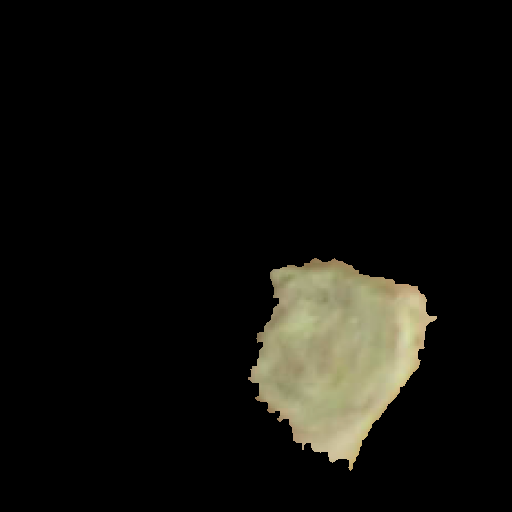

In [ ]:
#de gray vers bgr
from numpy.core.numeric import array_equiv
img_final=np.copy(masked_p)
for i in range(img_final.shape[0]):
  for j in range(img_final.shape[0]):
    if(np.array_equiv(img_final[i][j],[255,255,255]) ):
      img_final[i][j] = img[i][j]
cv2_imshow(img_final)

# **Segmentation avec K-means**
Nous avons choisi l'algorithme k-means pour la phase de la segmentation, car c'est un algorithme de clutering largement utilisé pour la segmentation d'image et pour sa robustesse.

253
9


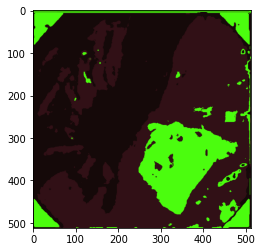

In [ ]:


#Il faut redimensionner l'image cielab en un tableau bidimentionnel
pixel_vals = lab.reshape((-1,3))

#converion en type float
pixel_vals = np.float32(pixel_vals)

#définir les conditions d'arret pour l'algorithme k-means
#on arrete a la 700eme itération ou le epsilon(le précision requise) est a 90% (ces deux conditions sont fixées expérimentalement cad apres plusieurs essais et executions)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 0.9)

#Le nombre de clusters
k = 3

#application de k-means 
#50 ==>  le nombre de fois que l'algorithme est exécuté en utilisant différents étiquetages initiaux
_, labels, (centers) = cv2.kmeans( np.float32(pixel_vals), k, None,criteria, 50, cv2.KMEANS_PP_CENTERS)

#conversion en valeurs de 8bits
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# flatten the labels array
labels = labels.flatten()
segmented_image = centers[labels]

#redimensionner envers les dimensions de l'image d'origine
segmented_image = segmented_image.reshape(lab.shape)

# show the image
print(np.max(segmented_image))
print(np.min(segmented_image))

plt.imshow(segmented_image)


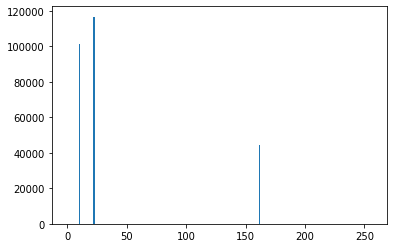

In [ ]:
seg_gray=cv2.cvtColor(segmented_image,cv2.COLOR_BGR2GRAY)
plt.hist(seg_gray.ravel(),256,[0,256]); plt.show()

Le seuillage:

253
9
122.0
thresh =  123.0


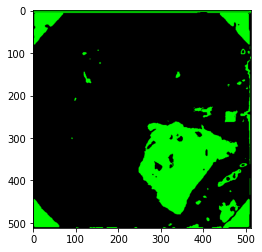

In [ ]:
hmax = np.max(segmented_image)
print(hmax)
hmin = np.min(segmented_image)
print(hmin)
print((hmax-hmin)/2)
maxval = np.max(segmented_image)
thresh=((hmax-hmin)/2)+1
print("thresh = ",thresh)
im_bin = (segmented_image > thresh) * maxval

plt.imshow(im_bin)

La binarisation

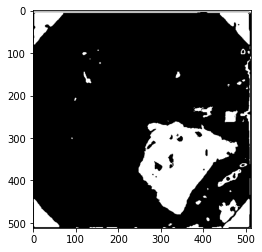

In [ ]:
img_bin=np.copy(im_bin)
for i in range(img_bin.shape[0]):
  for j in range(img_bin.shape[0]):
    if(not(np.array_equiv(img_bin[i][j],[0,0,0])) ):
      img_bin[i][j] = [255,255,255]
plt.imshow(img_bin)

La fermeture:

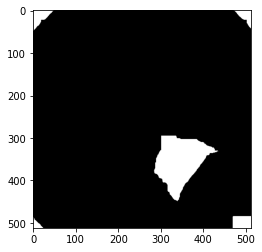

In [ ]:
kernel = np.ones((8,8), np.uint8)
dil_bin = cv2.dilate(img_bin, kernel, iterations=2)
#plt.imshow(dil_bin)
#ero_bin = cv2.erode(dil_bin, kernel, iterations=8)
ero_bin = cv2.erode(dil_bin, kernel, iterations=8)

plt.imshow(ero_bin)

La conversion de gray vers RGB:

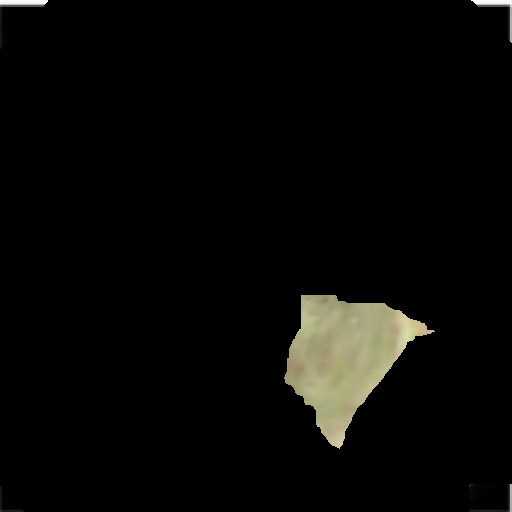

In [ ]:
#de gray vers bgr
from numpy.core.numeric import array_equiv
img_final=np.copy(ero_bin)
for i in range(img_final.shape[0]):
  for j in range(img_final.shape[0]):
    if(np.array_equiv(img_final[i][j],[255,255,255]) ):
      img_final[i][j] = img[i][j]
cv2_imshow(img_final)

#Conclusion :
Lors de ce projet, nous avons pu approfondir nos connaissances sur ce domaine, et utiliser beaucoup de notions de traitement d'image apprisent en cours et lors de la réalisation de nos tps.

#Merci °.°

In [ ]:

#masked_image = np.copy(segmented_image)
# convert to the shape of a vector of pixel values
#masked_image = masked_image.reshape((-1, 3))
#masquer les cluster 
#masked_image[labels == 0 ] = [0, 0, 0]
#masked_image[labels == 1 ] = [255, 255, 255]
#masked_image[labels == 2 ] = [0, 0, 0]
#masked_image[labels == 3 ] = [0,0,0]

# convert back to original shape
#masked_image = masked_image.reshape(segmented_image.shape)
# show the image
#print(masked_image)

#cv2_imshow(masked_image)
